# iris tomography codes

In [3]:
import sqlite3 as sql
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

## import data from database

In [4]:
orbit = 20900
num_of_orbits = 1
ch = 2

db = sql.connect('/home/anqil/Documents/Python/iris/OSIRIS_three_orbits_test.db')
cur = db.cursor()

return_column = ('data, mjd, look_ecef, sc_position_ecef, latitude, longitude, altitude')              
select_str = 'SELECT {} FROM IRI JOIN channel{} ON IRI.stw = channel{}.stw WHERE orbit>={} AND orbit<={}'
result = cur.execute(select_str.format(return_column, ch, ch, orbit, orbit+num_of_orbits))
all_image = result.fetchall()
db.close()

if len(all_image) == 0:
    print('No data for this orbit(s)')
    

print('num of images: {}'.format(len(all_image)))

num of images: 5792


## put data to arrays

In [5]:
l1_blob = np.array(all_image)[:,0]
mjd = np.array(all_image)[:,1].astype(float)
date = num2date(mjd, units)
sc_look_blob = np.array(all_image)[:,2]
sc_pos_blob = np.array(all_image)[:,3]
tan_lat_blob = np.array(all_image)[:,4]
tan_lon_blob = np.array(all_image)[:,5]
tan_alt_blob = np.array(all_image)[:,6]

#====unfolding blobs
l1 = np.empty((len(all_image),128))
sc_look = np.empty((len(all_image), 128, 3))
sc_pos = np.empty((len(all_image), 3))
tan_lat = np.empty((len(all_image),128))
tan_lon = np.empty((len(all_image),128))
tan_alt = np.empty((len(all_image),128))
for i in range(len(all_image)):
    l1[i,:] = np.frombuffer(l1_blob[i])
    sc_look[i,:,:] = np.frombuffer(sc_look_blob[i]).reshape(128,3)
    sc_pos[i,:] = np.frombuffer(sc_pos_blob[i])
    tan_lat[i,:] = np.frombuffer(tan_lat_blob[i])
    tan_lon[i,:] = np.frombuffer(tan_lon_blob[i])
    tan_alt[i,:] = np.frombuffer(tan_alt_blob[i])
#====construct xarray data array
pixel = np.arange(128)
l1 = xr.DataArray(l1, coords=(date, pixel), 
                  dims=('date', 'pixel'), 
                  attrs={'units':'Rayleigh??'})
sc_look = xr.DataArray(sc_look, coords=(date, pixel, ['x', 'y', 'z']), 
                       dims=('date', 'pixel', 'xyz'))
sc_pos = xr.DataArray(sc_pos, coords=(date, ['x', 'y', 'z']), dims=('date', 'xyz'))
tan_lat = xr.DataArray(tan_lat, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_lon = xr.DataArray(tan_lon, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_alt = xr.DataArray(tan_alt, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'meter'})


# build jacobian for the chosen images and pixels

In [6]:
#====choose mesurements
im_lst = np.arange(280,330,5)
pix_lst = np.arange(22,128)
#num of rows of jacobian
row_len = len(im_lst) * len(pix_lst)

#====define the bin edges (atmosphere grid)
edges_lat = np.linspace(tan_lat.isel(date=im_lst).min()-10, 
                        tan_lat.isel(date=im_lst).min()+10, 10)
edges_lon = np.linspace(tan_lon.isel(date=im_lst).min()-10,
                        tan_lon.isel(date=im_lst).min()+10, 10)
edges_alt = np.arange(25e3, 175e3, 2e3)
edges = edges_lat, edges_lon, edges_alt
#num of columns of jacobian
col_len = (len(edges_lat)+1)*(len(edges_lon)+1)*(len(edges_alt)+1) 

from geometry_functions import los_points_fix_dl, ecef2lla
from oem_functions import jacobian_row

dl = 3e3 #fixed distance between all points
nop = 500 # choose number of points along the line
K_row_idx = []
K_col_idx = []
K_value = []
dll = dl * np.ones(nop) #temp

measurement_id = 0
for image in im_lst:#range(im_start, im_end):
    #====generate points of los for all pixels in each image
    #====all points in ecef coordinate xyz
    lx, ly, lz = los_points_fix_dl(sc_look[image], sc_pos[image], dl=dl, nop=nop)    
    #====convert xyz to lat lon alt for all points
    los_lat, los_lon, los_alt = ecef2lla(lx, ly, lz)
    
    #====build K
    for pix in pix_lst:#range(pix_start, pix_end):   
        los = los_lat.sel(pixel=pix), los_lon.sel(pixel=pix), los_alt.sel(pixel=pix)
        measurement_idx, grid_idx, pathlength = jacobian_row(dll, edges, los, measurement_id)
        K_row_idx.append(measurement_idx)
        K_col_idx.append(grid_idx)
        K_value.append(pathlength)
        measurement_id += 1
        
K_row_idx = np.concatenate(K_row_idx).astype('int')
K_col_idx = np.concatenate(K_col_idx).astype('int')
K_value = np.concatenate(K_value) # in meter

#==== create sparse matrix
from scipy.sparse import coo_matrix
K_coo = coo_matrix((K_value, (K_row_idx, K_col_idx)), shape = (row_len, col_len))
#print(K_coo)

# MAP inversion

In [7]:
from oem_functions import linear_oem_sp
import scipy.sparse as sp
y = l1.isel(date=im_lst, pixel=pix_lst).data.ravel()
y[y<0] = 0
xa = np.ones(col_len) # temp
Sa = sp.diags([1], shape=(col_len, col_len)) *1 #temp
Se = sp.diags([1], shape=(measurement_id, measurement_id)) * 1e10 #temporary
x_hat = linear_oem_sp(K_coo, Se, Sa, y, xa)

result = x_hat.reshape(len(edges_lat)+1, len(edges_lon)+1, len(edges_alt)+1)
result = xr.DataArray(result[:-1,:-1,:-1], coords=(edges_lat, edges_lon, edges_alt), 
                      dims=('lat', 'lon', 'alt')) #temp


# Plot something


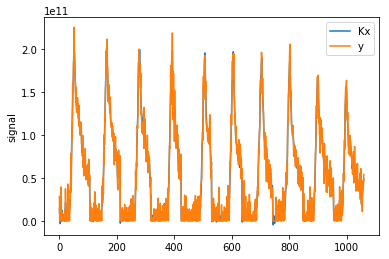

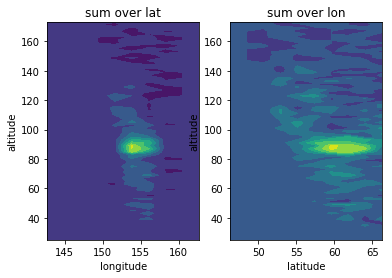

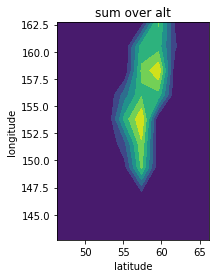

In [30]:
%matplotlib inline
#====check residual
plt.figure()
plt.plot(K_coo.dot(x_hat), label='Kx')
plt.plot(y, label='y')
plt.ylabel('signal')
plt.legend()
plt.show()

#====contour plot 
plt.figure()

plt.subplot(121)
plt.contourf(edges_lon, edges_alt*1e-3, result.sum(axis=0).T)
plt.xlabel('longitude')
plt.ylabel('altitude')
plt.title('sum over lat')

plt.subplot(122)
plt.contourf(edges_lat, edges_alt*1e-3, result.sum(axis=1).T)
plt.xlabel('latitude')
plt.ylabel('altitude')
plt.title('sum over lon')

plt.show()

plt.figure()
plt.subplot(122)
plt.contourf(edges_lat, edges_lon, result.sum(axis=2))
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('sum over alt')

plt.show()

In [158]:
R = 6370e3
flat_lat, flat_lon = edges_lat/180*np.pi*R*1e-3, edges_lon/180*np.pi*R*1e-3
print('horizontal extend',round(flat_lat[-1]-flat_lat[0]), round(flat_lon[-1]-flat_lon[0]), 'meter')

horizontal extend 2224.0 2224.0 meter


## visulize line of sights

In [22]:
from geometry_functions import los_points, ecef2lla
dl = 3e3 #fixed distance between all points
nop = 500 # choose number of points along the line
im_lst = np.arange(280,330,5)
pix_lst = np.arange(22,128,20)
lx, ly, lz = [], [], []
los_lat, los_lon, los_alt = [], [], []
for im in im_lst:
    lx_temp, ly_temp, lz_temp = los_points_fix_dl(sc_look.isel(date=im, pixel=pix_lst), 
                                   sc_pos.isel(date=im), dl=dl, nop=nop)    
    lx.append(lx_temp)
    ly.append(ly_temp)
    lz.append(lz_temp)
#lx, ly, lz = np.stack(lx, axis=0),np.stack(ly, axis=0),np.stack(lz, axis=0)
#los_lat, los_lon, los_alt = np.stack(los_lat), np.stack(los_lon), np.stack(los_alt)
lx = xr.DataArray(np.stack(lx,axis=0), coords=(im_lst, np.arange(nop), pix_lst), dims=('im', 'nop','pixel'))
ly = xr.DataArray(np.stack(ly,axis=0), coords=(im_lst, np.arange(nop), pix_lst), dims=('im', 'nop','pixel'))
lz = xr.DataArray(np.stack(lz,axis=0), coords=(im_lst, np.arange(nop), pix_lst), dims=('im', 'nop','pixel'))
los_lat, los_lon, los_alt = ecef2lla(lx, ly, lz)

<IPython.core.display.Javascript object>


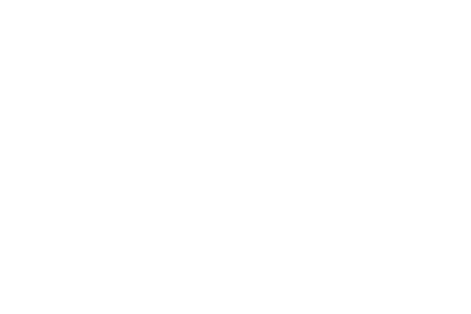

<IPython.core.display.Javascript object>


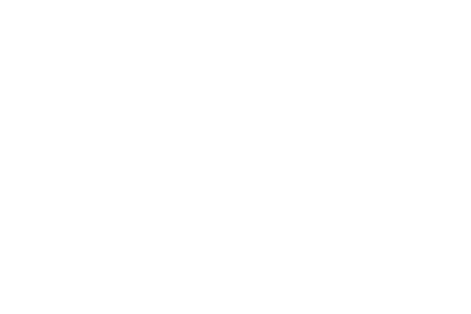

In [31]:
%matplotlib notebook
#plot los in 3d to check
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10
        
fig = plt.figure()
ax = fig.gca(projection='3d')
c = ('b', 'g', 'r', 'c', 'm', 'y', 'k')
for im in im_lst:
    for pix in pix_lst:
        ax.plot(los_lon.sel(im=im,pixel=pix), 
                los_lat.sel(im=im,pixel=pix),
                los_alt.sel(im=im,pixel=pix))

sx, sy, sz = sc_pos.isel(date=im_lst, xyz=0), sc_pos.isel(date=im_lst, xyz=1), sc_pos.isel(date=im_lst, xyz=2)
s_lat, s_lon, s_alt = ecef2lla(sx, sy, sz)
ax.set(xlabel='lon',
       ylabel='lat',
       zlabel='alt')

ax.scatter(s_lon, s_lat, s_alt)
ax.text(s_lon[0], s_lat[0], s_alt[0], 's')
plt.show()